# Optogenetic Stimulation Example

In [1]:
# if previously used Brian objects are preventing simulation
%reset -f
%load_ext autoreload
%autoreload 2

In [2]:
from brian2 import *
from clocsim.base import *

import matplotlib.pyplot as plt

## Create the Brian network

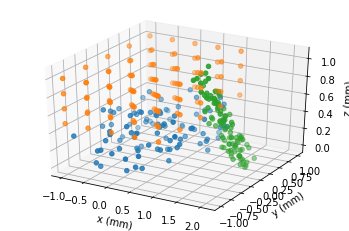

In [26]:
population = NeuronGroup(100,
    '''dv/dt = (-v - 70*mV + Rm*I) / tau : volt
    tau: second
    Rm: ohm
    I: amp''',
    threshold='v>-50*mV',
    reset='v=-70*mV'
)
population.tau = 10*ms
population.Rm = 100*Mohm
population.I = 0*mA
population.v = -70*mV

input_group = PoissonGroup(100, np.arange(100)*Hz + 10*Hz)

S = Synapses(input_group, population, on_pre='v+=5*mV')
S.connect(condition=f'abs(i-j)<={3}')
S2 = Synapses(population, population, on_pre='v+=2*mV')
S2.connect(condition=f'abs(i-j)<={1}')
# S2.connect(p=0.1)

pop_mon = SpikeMonitor(population)

from clocsim.utilities import modify_model_with_eqs
# modify_model_with_eqs(population, 
#         '''x: meter
#         y: meter
#         z: meter
#         r: meter
#         zh: meter
#         Ir: watt / meter
#         ''')
# population.add_attribute('x')
# population.x = 5*mm
# population.equations += Equations('x: meter')
# population.x = np.linspace(-1, 1, 100)*mm

pop2 = NeuronGroup(100, '')
pop3 = NeuronGroup(100, '')

from clocsim.coordinates import assign_coords_rect_prism, plot_neuron_positions, assign_coords_cylinder
assign_coords_rect_prism(pop2, 'grid', xlim=(-1, 1), ylim=(-1, 1), 
    zlim=(0.5, 1), unit=mm, xyz_grid_shape=(5,5,4))
assign_coords_rect_prism(population, 'random', xlim=(-1, 1), ylim=(-1, 1), 
    zlim=(0, 0.5), unit=mm)
assign_coords_cylinder(pop3, 'random', xyz_start=(2,0,0), xyz_end=(1,0,1), radius=0.2)

plot_neuron_positions(population, pop2, pop3)
# %matplotlib widget
# plot_neuron_positions(pop3, xlim=(.5, 1.5), ylim=(0, 1))


### Run simulation without control:

In [4]:
net = Network(collect())
net.run(100*ms)

INFO       No numerical integration method specified for group 'neurongroup', using method 'exact' (took 0.27s). [brian2.stateupdaters.base.method_choice]


In [5]:
fig_size=(7, 3)
plt.figure(figsize=fig_size);
plt.plot(pop_mon.t / ms, pop_mon.i, '.'); 
plt.title('Population Spiking'); plt.ylabel('neuron index'); plt.xlabel('time (ms)');

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Control loop setup
Now for the control loop--to control neuron $i$, we need to:
- capture spiking using a `SpikeRecorder`
- estimating its firing rate using a `FiringRateEstimator`
- compute the stimulus intensity with a `PIController`
- pass that to a `StateVariableSetter` stimulator manipulating input current

### Example optogenetic stimulation setup

In [6]:
# need to assign coordinates beforehand; could use same coordinates
# for spatial recording profiles as well.
assign_coordinates(L2, 'uniform', xlim=(-1, 1)*mm, ylim=(-1, 1)*mm, zlim=(0, 0.3*mm))
assign_coordinates(L3, 'uniform', xlim=(-1, 1)*mm, ylim=(-1, 1)*mm, zlim=(0.3, 0.8)*mm)

opto = OptogeneticIntervention(name='opto', delivery='fiber', opsin='ChR2', wavelength=473*nm)
# default location is the origin; default orientation = (0, 0, 1)
# i.e., z-axis is vertical distance from light source by default
sim.inject_stimulator(opto, L2, L3)
# under the hood, opto will modify the model equations of these neuron groups
# so Brian can simulate the opsin dynamics

NameError: name 'assign_coordinates' is not defined

In [7]:
from clocsim.base import *
from clocsim.recorders import GroundTruthSpikeRecorder
from clocsim.stimulators import StateVariableSetter

i = 20  # neuron to control

sim = CLOCSimulator(net)
rec = GroundTruthSpikeRecorder('spike_rec', index=i)
sim.inject_recorder(rec, population)

ImportError: cannot import name 'nm' from 'brian2' (C:\Users\johns\.conda\envs\brian2genn\lib\site-packages\brian2\__init__.py)

Note that we can set delays for components in the control loop to better
approximate the experiment:

In [8]:
from clocsim.control_loop import DelayControlLoop
from clocsim.control_loop.observers import FiringRateEstimator
from clocsim.control_loop.delays import ConstantDelay
from clocsim.control_loop.controllers import PIController

# the target firing rate trajectory, as a function of time
def target_Hz(t_ms):
    if t_ms < 250:  # constant target at first
        return 400
    else:  # sinusoidal afterwards
        a = 200
        t_s = t_ms / 1000
        return a + a*np.sin(2*np.pi*20*t_s)

class PIRateControlLoop(DelayControlLoop):
    delta = 1  # ms
    def __init__(self):
        super().__init__(self.delta, sampling='fixed', processing='parallel')
        self.rate_estimator = FiringRateEstimator(10, self.delta,
                delay=ConstantDelay(5.1), save_history=True)

        self.pi_controller = PIController(target_Hz, Kp=0.005, Ki=0.001, 
                sample_period_ms=self.delta, delay=ConstantDelay(2.87),
                save_history=False)

    def compute_ctrl_signal(self, state_dict, time_ms):
        spikes = state_dict['spike_rec']
        out, time_ms = self.rate_estimator.process_data(spikes, time_ms)
        out, time_ms = self.pi_controller.process_data(out, time_ms)
        # this dictionary output format allows for the flexibility
        # of controlling multiple stimulators
        if out < 0:  # limit to positive current
            out = 0
        out_dict = {'I_stim': out}  
        return out_dict, time_ms

ctrl_loop = PIRateControlLoop()
sim.set_control_loop(ctrl_loop)

SyntaxError: invalid syntax (controllers.py, line 25)

In [9]:
sim.inject_stimulator(
        StateVariableSetter(
            'I_stim', index=i, variable_to_ctrl='I', unit=nA),
        population
)

NameError: name 'sim' is not defined

## Run the simulation

In [10]:
sim.run(300*ms)

NameError: name 'sim' is not defined

In [11]:
fig_size=(7, 3)
fig, ax = plt.subplots(figsize=fig_size);
ax.plot(pop_mon.t / ms, pop_mon.i, '.');
ax.plot(pop_mon.t[pop_mon.i == i]/ms, pop_mon.i[pop_mon.i==i], '.', c='xkcd:hot pink') 
plt.title('Population Spiking'); plt.ylabel('neuron index'); plt.xlabel('time (ms)');
# ax2 = ax.secondary_yaxis('right')
ax.plot()
plt.show()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

NameError: name 'i' is not defined

In [12]:
plt.figure(figsize=fig_size);
plt.plot(ctrl_loop.rate_estimator.t, ctrl_loop.rate_estimator.values, c='xkcd:hot pink');
plt.plot(ctrl_loop.rate_estimator.t, [target_Hz(t) for t in ctrl_loop.rate_estimator.t],\
        c='xkcd:green');
plt.ylabel('firing rate (Hz)'); plt.xlabel('time (ms)');
plt.legend(['Estimated firing rate', 'Target firing rate']);
plt.title(f'Neuron {i} activity');

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

NameError: name 'ctrl_loop' is not defined

_Note the lag in keeping up with the target firing rate, which can
be directly attributed to the ~8 ms delay we coded in to the control loop._